In this vignette I will show some of the geographic charactaristics of the ecoregions used in this study and how these are used to delineate major ecoregion groups

First, we will load the necessary packages to run the code

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################
# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.colors as mcolors




Define any global filepaths and variables that will be needed throughout the script

In [2]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
NLCD_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/NLCD/'
elev_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/SRTM/WUS/'
MAP_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/GRIDMET/Precip/05d_1980-2010_mean/'

TCC_file = os.path.join(NLCD_dir, 'TreeCover/2019/NLCD_TCC_05d_WUS_2019.nc')
EPA_ecoregion_L3_file = os.path.join(EPA_ecoregion_dir, 'L3', 'WUS_cec_eco_l3.shp')
elev_file = os.path.join(elev_dir, 'SRTM_DEM_05d_WUS.nc')
MAP_file = os.path.join(MAP_dir, 'GRIDMET_TotalWYPrecip_WUS_1980-2010_mean.nc')

########################################
# Define Global Variables and constants
#########################################

# Define the averaging window definition for "annual" values
timing_label = 'FULL_YEAR' # options: "FULL_YEAR", "TOP_QUARTILE", "POST_PEAK_LAI", "PRE_PEAK_LAI"
dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label
analysis_years = range(2018, 2024)

## Define paths to data files
TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]

#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



Define any functions that will be needed throughout the script

In [3]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr

Load all the relevant  datasets, including:
    -TROPOMI SIF
    -NASA SRTM elevation data
    -National Land Cover Database (NLCD) Tree Canopy Cover data
    -GRIDMET historical avg mean annual precipitation (1980-2010)
Note that all datasets have been spatially regridded to 0.05° grid resolution

In [4]:

###### Load all the files as xarray dataarrays
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF

# Load tree canopy cover, elevation and mean annual precipitation
TCC_xr = xr.open_dataset(TCC_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['tree_canopy_cover'] # NLCD Tree Cover
elev_xr = xr.open_dataset(elev_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['elevation'] # SRTM Elevation
MAP_xr = xr.open_dataset(MAP_file, decode_coords='all').sortby(['x', 'y'], ascending = True)['mean'] # GRIDMET Mean Annual Precipitation

# Mask out the unused data which are not "ENF" type
TCC_xr_mask = TCC_xr.where(~np.isnan(TROPOMI_SIF_xr))
elev_xr_mask = elev_xr.where(~np.isnan(TROPOMI_SIF_xr))
MAP_xr_mask = MAP_xr.where(~np.isnan(TROPOMI_SIF_xr))


### Visualize the data

Let's plot some maps of the datasets just to understand their patterns

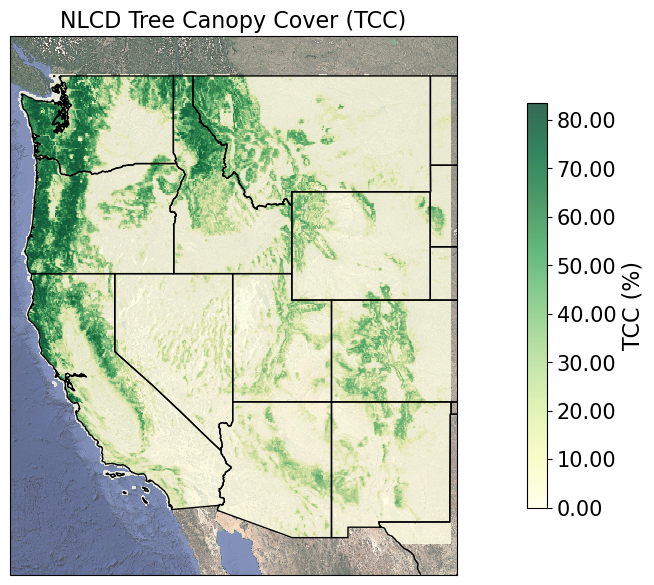

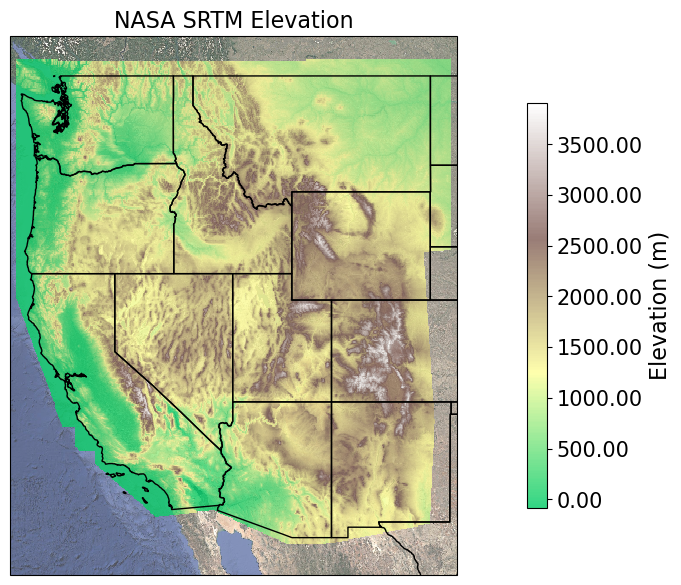

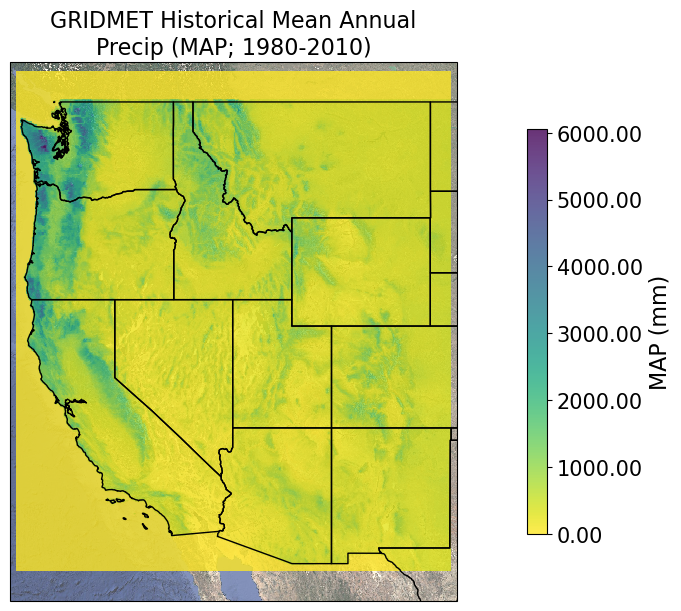

In [7]:
def plot_dataarray_map(dat_da, plotTitle, zax_label, plot_min=None, plot_max=None, cmap='inferno_r'):
    if plot_min is None:
        plot_min = np.nanmin(dat_da.values)
    if plot_max is None:
        plot_max = np.nanmax(dat_da.values)
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7) # Add base image

    # add state boundaries to the map
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

    dat_da.plot(ax=ax, transform=transform, alpha=alpha, 
                    cmap=cmap, vmin = plot_min, vmax = plot_max,
                        cbar_kwargs={'orientation': 'vertical',
                                            'pad': 0.1,
                                            'label': zax_label,
                                            'shrink': 0.75,
                                            'format': FFmt(z_axis_formatter)})

    plt.title(plotTitle) # set axis title
    plt.show()



# Plot NLCD Tree Canopy Cover
plot_dataarray_map(TCC_xr, 'NLCD Tree Canopy Cover (TCC)', 
    'TCC (%)', cmap='YlGn')

# Plot NASA SRTM Elevation
# Custom terrain colormap for the elevation map - land only
terrain_colors = plt.cm.terrain(np.linspace(0.25, 1, 256))  # Skip the blue/water colors at the start
custom_terrain_cmap = mcolors.LinearSegmentedColormap.from_list('custom_terrain', terrain_colors)
plot_dataarray_map(elev_xr, 'NASA SRTM Elevation', 
    'Elevation (m)', cmap=custom_terrain_cmap)

# Plot GRIDMET Historical Mean Annual Precipitation
plot_dataarray_map(MAP_xr, 'GRIDMET Historical Mean Annual\nPrecip (MAP; 1980-2010)', 
    'MAP (mm)', cmap='viridis_r')


### EPA Level III Ecoregions

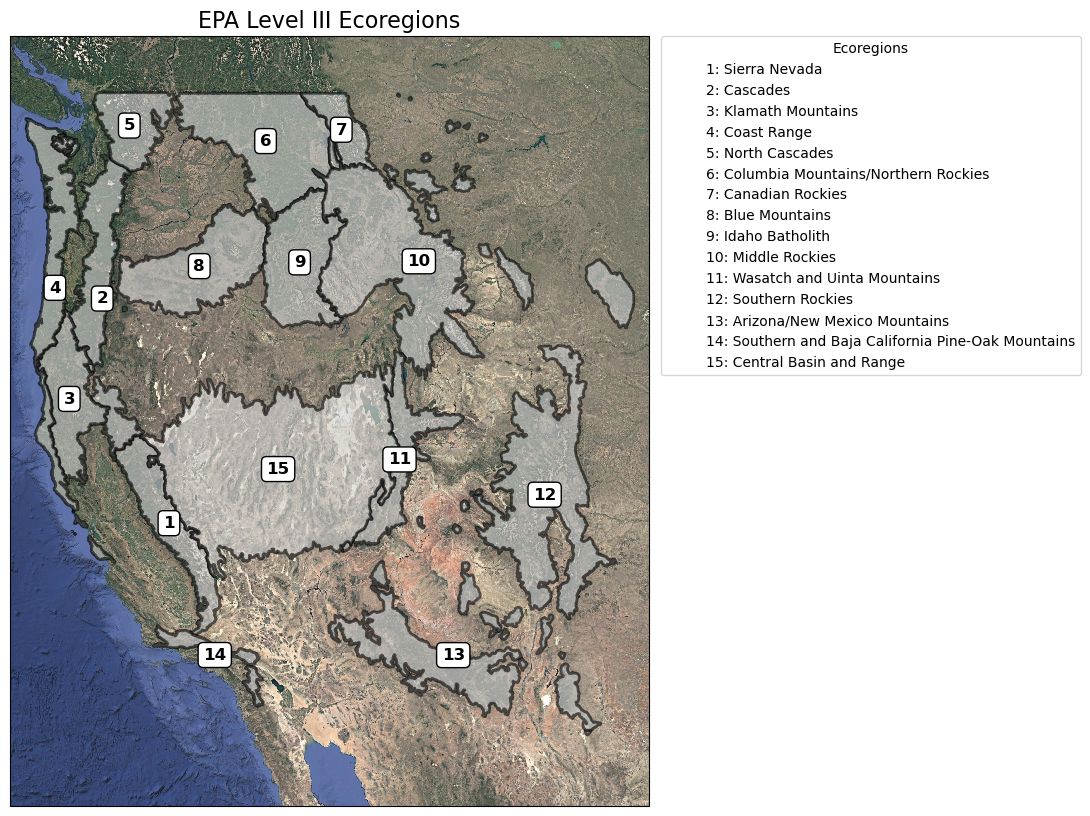

In [8]:

# Load EPA L3 Ecoregion file and define individual region geometries
ecoregion_l3_gdf = gpd.read_file(EPA_ecoregion_L3_file)
Region1 = ['Sierra Nevada']
Region2 = ['Cascades']
Region3 = ['Klamath Mountains']
Region4 = ['Coast Range']
Region5 = ['North Cascades']
Region6 = ['Columbia Mountains/Northern Rockies']
Region7 = ['Canadian Rockies']
Region8 = ['Blue Mountains']
Region9 = ['Idaho Batholith'] 
Region10 = ['Middle Rockies']
Region11 = ['Wasatch and Uinta Mountains']
Region12 = ['Southern Rockies']
Region13 = ['Arizona/New Mexico Mountains']
Region14 = ['Southern and Baja California Pine-Oak Mountains']
Region15 = ['Central Basin and Range']

ecoregion_l3_gdf_Region1 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region1)]
ecoregion_l3_geom_Region1 = ecoregion_l3_gdf_Region1.geometry

ecoregion_l3_gdf_Region2 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region2)]
ecoregion_l3_geom_Region2 = ecoregion_l3_gdf_Region2.geometry

ecoregion_l3_gdf_Region3 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region3)]
ecoregion_l3_geom_Region3 = ecoregion_l3_gdf_Region3.geometry

ecoregion_l3_gdf_Region4 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region4)]
ecoregion_l3_geom_Region4 = ecoregion_l3_gdf_Region4.geometry

ecoregion_l3_gdf_Region5 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region5)]
ecoregion_l3_geom_Region5 = ecoregion_l3_gdf_Region5.geometry

ecoregion_l3_gdf_Region6 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region6)]
ecoregion_l3_geom_Region6 = ecoregion_l3_gdf_Region6.geometry

ecoregion_l3_gdf_Region7 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region7)]
ecoregion_l3_geom_Region7 = ecoregion_l3_gdf_Region7.geometry

ecoregion_l3_gdf_Region8 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region8)]
ecoregion_l3_geom_Region8 = ecoregion_l3_gdf_Region8.geometry

ecoregion_l3_gdf_Region9 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region9)]
ecoregion_l3_geom_Region9 = ecoregion_l3_gdf_Region9.geometry

ecoregion_l3_gdf_Region10 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region10)]
ecoregion_l3_geom_Region10 = ecoregion_l3_gdf_Region10.geometry

ecoregion_l3_gdf_Region11 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region11)]
ecoregion_l3_geom_Region11 = ecoregion_l3_gdf_Region11.geometry

ecoregion_l3_gdf_Region12 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region12)]
ecoregion_l3_geom_Region12 = ecoregion_l3_gdf_Region12.geometry

ecoregion_l3_gdf_Region13 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region13)]
ecoregion_l3_geom_Region13 = ecoregion_l3_gdf_Region13.geometry

ecoregion_l3_gdf_Region14 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region14)]
ecoregion_l3_geom_Region14 = ecoregion_l3_gdf_Region14.geometry

ecoregion_l3_gdf_Region15 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region15)]
ecoregion_l3_geom_Region15 = ecoregion_l3_gdf_Region15.geometry

region_names = ['Sierra Nevada', 'Cascades', 'Klamath Mountains', 'Coast Range', 
                'North Cascades', 'Columbia Mountains/Northern Rockies', 'Canadian Rockies',
                'Blue Mountains', 'Idaho Batholith', 'Middle Rockies',
                'Wasatch and Uinta Mountains', 'Southern Rockies', 'Arizona/New Mexico Mountains', 
                'Southern and Baja California Pine-Oak Mountains', 'Central Basin and Range']

# List of region geometries and names
region_geoms = [
    ecoregion_l3_geom_Region1, ecoregion_l3_geom_Region2, ecoregion_l3_geom_Region3,
    ecoregion_l3_geom_Region4, ecoregion_l3_geom_Region5, ecoregion_l3_geom_Region6,
    ecoregion_l3_geom_Region7, ecoregion_l3_geom_Region8, ecoregion_l3_geom_Region9,
    ecoregion_l3_geom_Region10, ecoregion_l3_geom_Region11, ecoregion_l3_geom_Region12,
    ecoregion_l3_geom_Region13, ecoregion_l3_geom_Region14, ecoregion_l3_geom_Region15
]


#### Plot a map of ecoregions
figsize = (12, 10)  # width, height in inches
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.9) # Add base image

alpha = 0.65  # transparency 0-1

# Plot numbered text boxes at centroids of each region
import matplotlib.patches as mpatches

ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region4, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region5, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region6, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region7, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region8, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region9, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region10, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region11, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region12, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region13, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region14, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region15, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)

for i, geom_series in enumerate(region_geoms):
    # Use the union of parts to get a representative centroid for the region
    union_geom = geom_series.union_all()
    cent = union_geom.centroid
    ax.text(cent.x, cent.y, str(i + 1),
            transform=transform,
            fontsize=12, fontweight='bold',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3'),
            zorder=10)

# Build legend: number -> region name
labels = [f"{i+1}: {name}" for i, name in enumerate(region_names)]
proxies = [mpatches.Patch(facecolor=None, edgecolor=None, alpha=0) for _ in labels]
ax.legend(proxies, labels, loc='upper left', bbox_to_anchor=(1.02, 1.0),
          borderaxespad=0., fontsize=10, title='Ecoregions')
plt.xlabel('lon', fontsize=10)
plt.ylabel('lat', fontsize=10)
plt.title('EPA Level III Ecoregions') # set axis title
plt.show()

### Distribution of Tree Canopy Cover by ecoregion


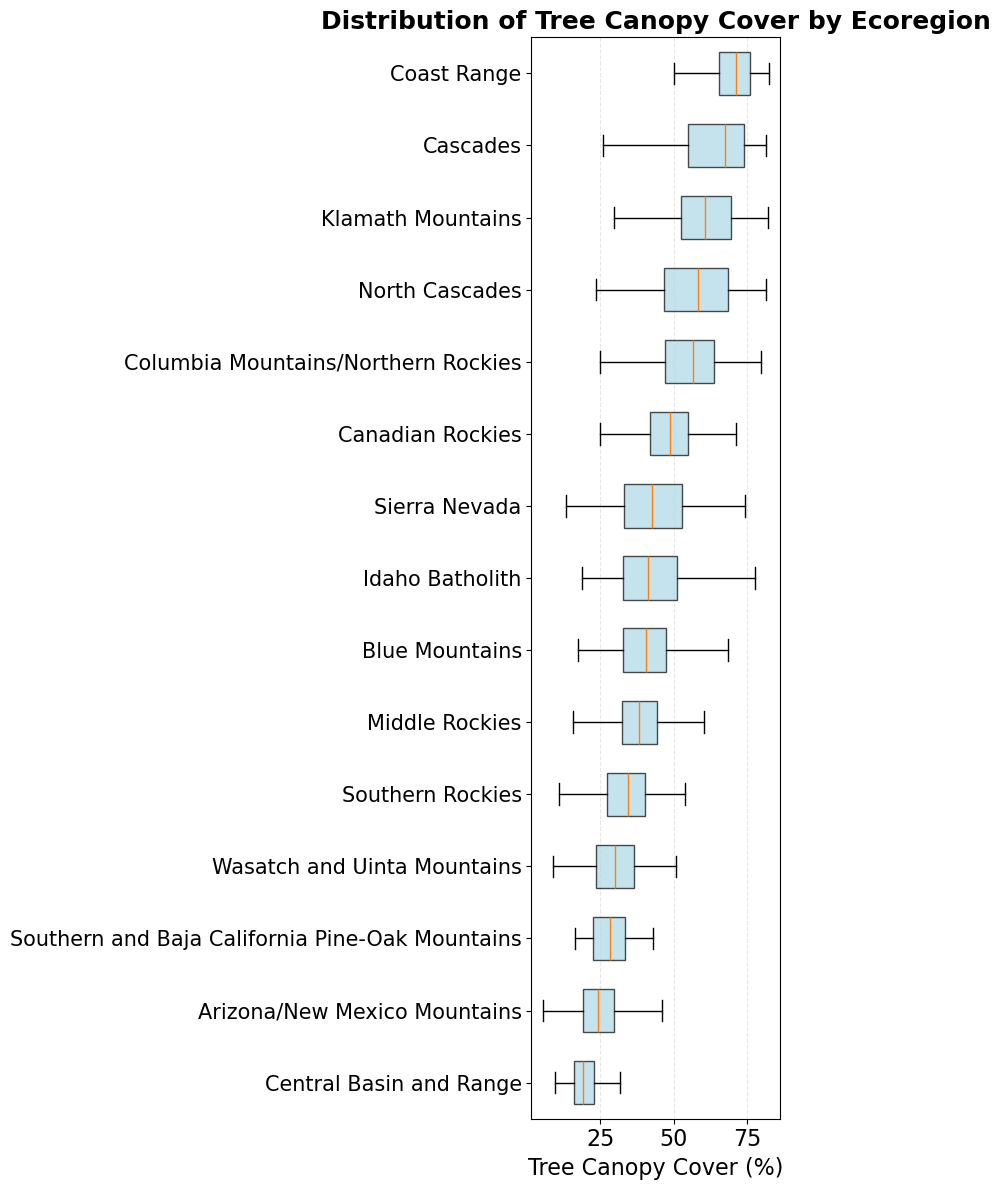

In [9]:
# Create figure for TCC distributions across ecoregions
fig, ax = plt.subplots(figsize=(8, 12))

# Collect TCC data for each region
tcc_data_by_region = []
region_labels = []

for i, (region_geom, region_name) in enumerate(zip(region_geoms, region_names)):
    # Clip TCC data to the current ecoregion
    TCC_clipped = TCC_xr_mask.rio.write_crs(4326).rio.clip(region_geom, drop=True)
    
    # Extract values and remove NaNs
    tcc_values = TCC_clipped.values.flatten()
    tcc_values = tcc_values[~np.isnan(tcc_values)]
    
    if len(tcc_values) > 0:
        tcc_data_by_region.append(tcc_values)
        region_labels.append(region_name)

# Sort regions by median TCC value
TCC_medians = [np.median(data) for data in tcc_data_by_region]
sorted_indices = np.argsort(TCC_medians)
tcc_data_by_region = [tcc_data_by_region[i] for i in sorted_indices]
region_labels = [region_labels[i] for i in sorted_indices]

# Create box-whisker plot with vertical orientation
bp = ax.boxplot(tcc_data_by_region, tick_labels=region_labels, patch_artist=True,
                showfliers=False, widths=0.6, vert=False)

# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# No rotation needed for y-axis labels
ax.set_yticklabels(region_labels)

# Labels and title (swapped x and y)
ax.set_xlabel('Tree Canopy Cover (%)', fontsize=16)
ax.set_title('Distribution of Tree Canopy Cover by Ecoregion', fontsize=18, fontweight='bold')

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)


# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Distribution of Elevation by ecoregion


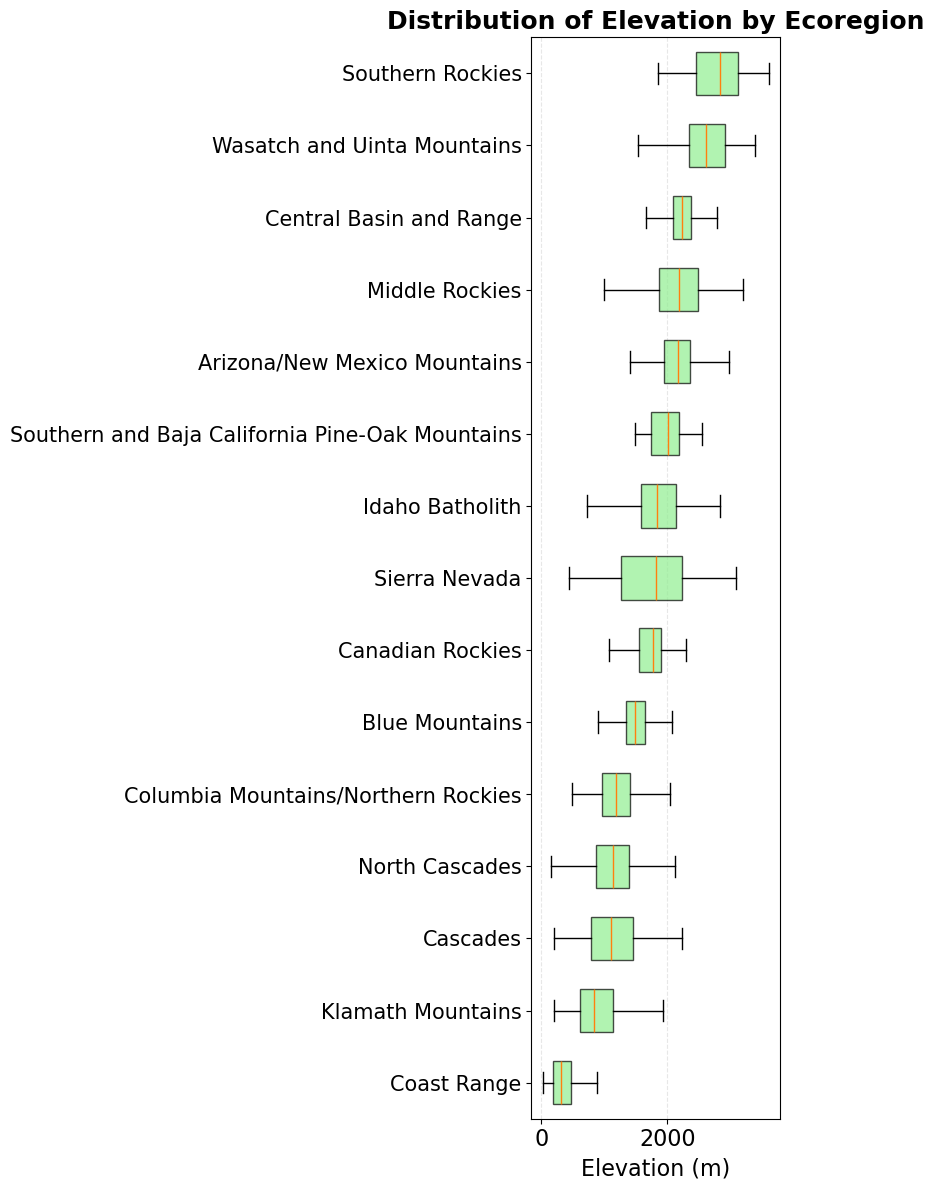

In [10]:

# Create figure for Elevation distributions across ecoregions
fig, ax = plt.subplots(figsize=(8, 12))

# Collect elevation data for each region
elev_data_by_region = []
region_labels = []

for i, (region_geom, region_name) in enumerate(zip(region_geoms, region_names)):
    # Clip elevation data to the current ecoregion
    elev_clipped = elev_xr_mask.rio.write_crs(4326).rio.clip(region_geom, drop=True)
    
    # Extract values and remove NaNs
    elev_values = elev_clipped.values.flatten()
    elev_values = elev_values[~np.isnan(elev_values)]
    
    if len(elev_values) > 0:
        elev_data_by_region.append(elev_values)
        region_labels.append(region_name)

# Sort regions by median elevation value
elev_medians = [np.median(data) for data in elev_data_by_region]
sorted_indices = np.argsort(elev_medians)
elev_data_by_region = [elev_data_by_region[i] for i in sorted_indices]
region_labels = [region_labels[i] for i in sorted_indices]

# Create box-whisker plot with vertical orientation
bp = ax.boxplot(elev_data_by_region, tick_labels=region_labels, patch_artist=True,
                showfliers=False, widths=0.6, vert=False)

# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_alpha(0.7)

# No rotation needed for y-axis labels
ax.set_yticklabels(region_labels)

# Labels and title (swapped x and y)
ax.set_xlabel('Elevation (m)', fontsize=16)
ax.set_title('Distribution of Elevation by Ecoregion', fontsize=18, fontweight='bold')

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Distribution of Mean Annual Precipitation (MAP) by ecoregion

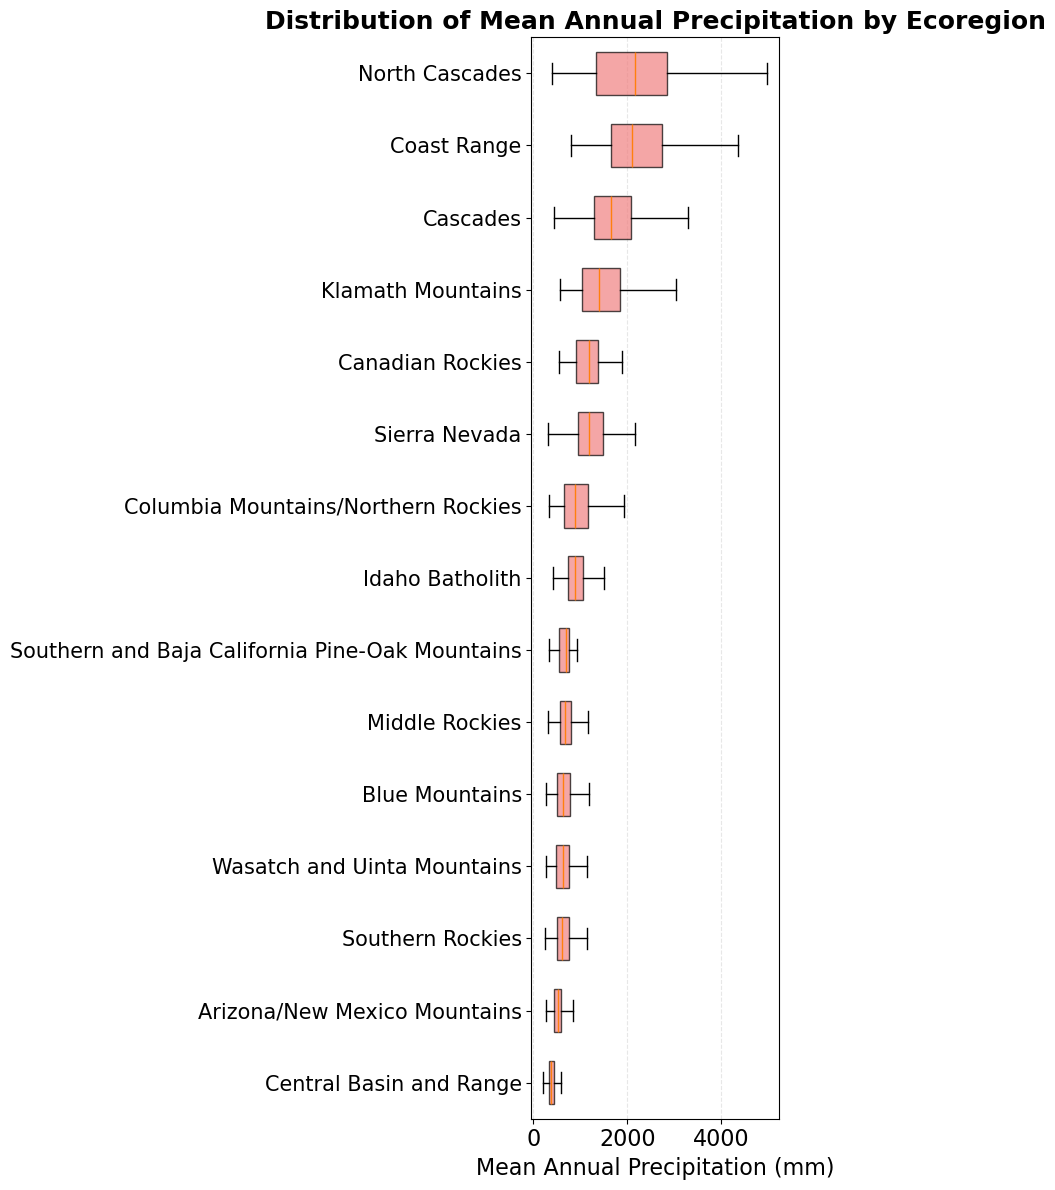

In [11]:
# Create figure for MAP distributions across ecoregions
fig, ax = plt.subplots(figsize=(8, 12))

# Collect MAP data for each region
map_data_by_region = []
region_labels = []

for i, (region_geom, region_name) in enumerate(zip(region_geoms, region_names)):
    # Clip MAP data to the current ecoregion
    MAP_clipped = MAP_xr_mask.rio.write_crs(4326).rio.clip(region_geom, drop=True)
    
    # Extract values and remove NaNs
    map_values = MAP_clipped.values.flatten()
    map_values = map_values[~np.isnan(map_values)]
    
    if len(map_values) > 0:
        map_data_by_region.append(map_values)
        region_labels.append(region_name)

# Sort regions by median MAP value
map_medians = [np.median(data) for data in map_data_by_region]
sorted_indices = np.argsort(map_medians)
map_data_by_region = [map_data_by_region[i] for i in sorted_indices]
region_labels = [region_labels[i] for i in sorted_indices]

# Create box-whisker plot with vertical orientation
bp = ax.boxplot(map_data_by_region, tick_labels=region_labels, patch_artist=True,
                showfliers=False, widths=0.6, vert=False)

# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
    patch.set_alpha(0.7)

# No rotation needed for y-axis labels
ax.set_yticklabels(region_labels)

# Labels and title (swapped x and y)
ax.set_xlabel('Mean Annual Precipitation (mm)', fontsize=16)
ax.set_title('Distribution of Mean Annual Precipitation by Ecoregion', fontsize=18, fontweight='bold')

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Visualizing all 3 variables together (by ecoregion)

Now let's take the median values of the distributions of all 3 variables and plot them in a scatterplot with a similar layout to a [Whittaker diagram](https://gveg.wyobiodiversity.org/application/files/7916/4641/2117/Whittaker_Diagram_Guide.pdf) But with elevation on the y axis and precipitation on the x axis. We will charactarize ecoregions by tree canopy coverage using the size of the marker.

We will use this to group by ecoregion (see colors of points)

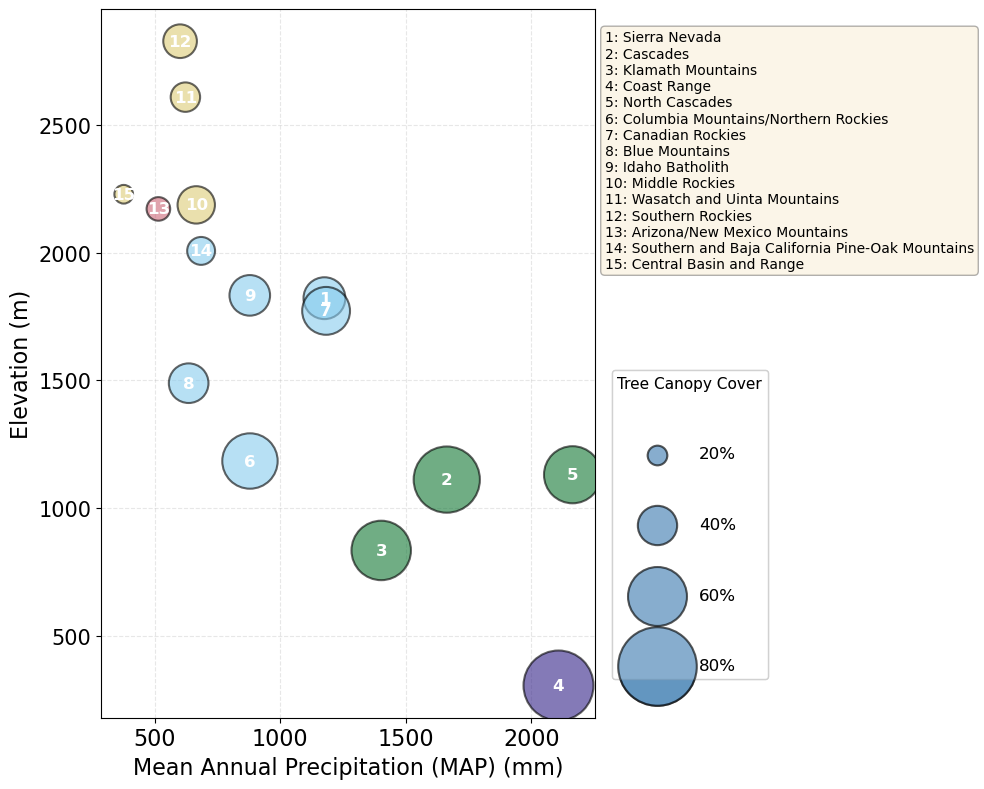

In [14]:

Coastal_color = '#332288'
Pacific_Montane_color = '#117733'
Mid_Montane_color = "#88CCEE"
Rockies_color = '#DDCC77'
AZNM_color = '#CC6677'

# Assign colors to each region based on groupings
region_colors = []
for i in range(len(region_names)):
    region_num = i + 1  # Region numbers are 1-indexed
    if region_num == 4:  # Coastal
        region_colors.append(Coastal_color)
    elif region_num in [2, 3, 5]:  # Pacific Montane
        region_colors.append(Pacific_Montane_color)
    elif region_num in [6, 7, 1, 8, 9, 14]:  # Mid Montane
        region_colors.append(Mid_Montane_color)
    elif region_num in [10, 11, 12, 15]:  # Rockies (excluding 13)
        region_colors.append(Rockies_color)
    elif region_num == 13:  # AZNM
        region_colors.append(AZNM_color)
    else:
        region_colors.append('gray')  # fallback color

# Create scatter plot of Elevation vs MAP by ecoregion (axes flipped)
fig, ax = plt.subplots(figsize=(8, 8))
# Scale marker sizes proportional to TCC median (scale for visibility)

marker_sizes = (np.array(TCC_medians)**2) * 0.5  # Adjust multiplier as needed

# Create scatter plot with flipped axes
scatter = ax.scatter(map_medians, elev_medians, s=marker_sizes, 
                     c=region_colors, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add labels (1-15) on the scatter points
for i, (elev, map_val, label) in enumerate(zip(elev_medians, map_medians, region_names)):
    ax.text(map_val, elev, str(i+1), fontsize=12, ha='center', va='center', 
            fontweight='bold', color='white')
# Create a size legend for TCC
# Create dummy scatter points for legend (representative TCC values)
tcc_legend_values = [20, 40, 60, 80]  # Representative TCC percentages
tcc_legend_sizes = [(val**2) * 0.5 for val in tcc_legend_values]

# Create legend handles with custom spacing
legend_handles = [plt.scatter([], [], s=size, c='steelblue', alpha=0.6, 
                                edgecolors='black', linewidth=1.5) 
                    for size in tcc_legend_sizes]

# Add size legend outside plot area on top right with increased vertical spacing
size_legend = ax.legend(legend_handles, [f'{val}%' for val in tcc_legend_values],
                        title='Tree Canopy Cover', loc='upper left', 
                        bbox_to_anchor=(1.02, 0.5),
                        frameon=True, fontsize=10, title_fontsize=11,
                        labelspacing=4,  # Increase vertical spacing between legend entries
                        handletextpad=2.0)  # Increase horizontal spacing between markers and labels
# Adjust size legend properties for larger labels
for text in size_legend.get_texts():
    text.set_fontsize(12)  # Increase label font size

ax.add_artist(size_legend)  # Keep this legend when adding region labels
# Create legend with region number and name
legend_labels = [f"{i+1}: {label}" for i, label in enumerate(region_names)]
legend_text = '\n'.join(legend_labels)
ax.text(1.02, 0.8, legend_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Labels and title (axes flipped)
ax.set_xlabel('Mean Annual Precipitation (MAP) (mm)', fontsize=16)
ax.set_ylabel('Elevation (m)', fontsize=16)

# Add grid
ax.grid(alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)

plt.show()

#### Map view of ecoregion groups

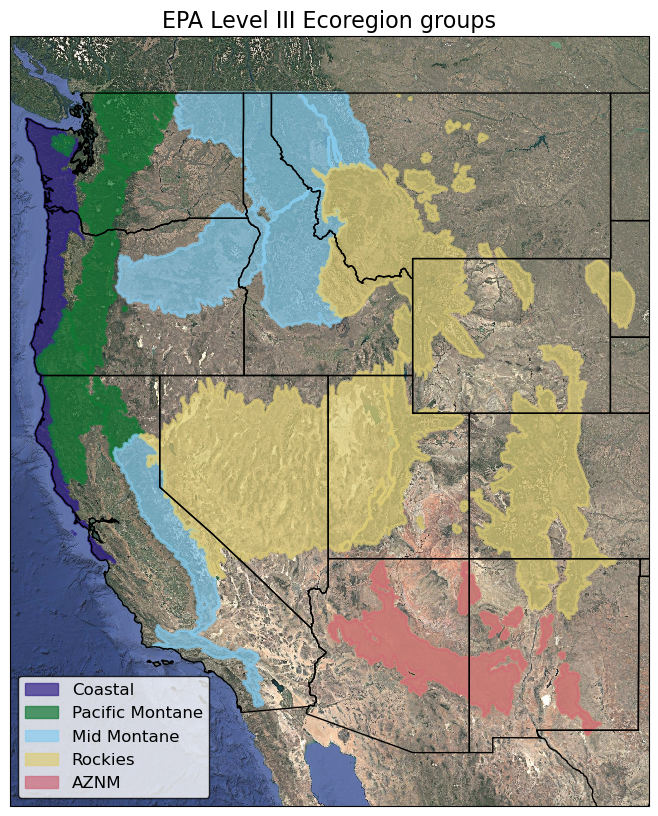

In [15]:
region_gdfs_Coastal = [ecoregion_l3_gdf_Region4]
region_gdfs_Pacific_Montane = [ecoregion_l3_gdf_Region2, ecoregion_l3_gdf_Region3,
                                ecoregion_l3_gdf_Region5]
region_gdfs_Mid_Montane = [ecoregion_l3_gdf_Region6, ecoregion_l3_gdf_Region7,
                        ecoregion_l3_gdf_Region1, ecoregion_l3_gdf_Region8, 
                        ecoregion_l3_gdf_Region9, ecoregion_l3_gdf_Region14]

region_gdfs_Rockies_group = [ecoregion_l3_gdf_Region10, ecoregion_l3_gdf_Region11,
                                ecoregion_l3_gdf_Region12, ecoregion_l3_gdf_Region13,
                                ecoregion_l3_gdf_Region15]
region_gdfs_AZNM_group = [ecoregion_l3_gdf_Region13]

# Combine GeoDataFrames for each region group
region_gdfs_Coastal_group = pd.concat(region_gdfs_Coastal, ignore_index=True)
region_gdfs_Pacific_Montane_group = pd.concat(region_gdfs_Pacific_Montane, ignore_index=True)
region_gdfs_Mid_Montane_group = pd.concat(region_gdfs_Mid_Montane, ignore_index=True)
region_gdfs_Rockies_group = pd.concat(region_gdfs_Rockies_group, ignore_index=True)
region_gdfs_AZNM_group = pd.concat(region_gdfs_AZNM_group, ignore_index=True)

# Calculate combined geometries
region_geom_Coastal = region_gdfs_Coastal_group.geometry
region_geom_Pacific_Montane = region_gdfs_Pacific_Montane_group.geometry
region_geom_Mid_Montane = region_gdfs_Mid_Montane_group.geometry
region_geom_Rockies = region_gdfs_Rockies_group.geometry
region_geom_AZNM = region_gdfs_AZNM_group.geometry

#### Plot a map of ecoregions
figsize = (12, 10)  # width, height in inches
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.9) # Add base image

alpha = 0.75  # transparency 0-1

# Plot numbered text boxes at centroids of each region
import matplotlib.patches as mpatches
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
# for geom_region in region_geoms_Pacific_group:
ax.add_geometries(region_geom_Coastal, crs=transform, facecolor="#332288", edgecolor='#332288', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(region_geom_Pacific_Montane, crs=transform, facecolor="#117733", edgecolor='#117733', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(region_geom_Mid_Montane, crs=transform, facecolor="#88CCEE", edgecolor='#88CCEE', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(region_geom_Rockies, crs=transform, facecolor="#DDCC77", edgecolor='#DDCC77', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(region_geom_AZNM, crs=transform, facecolor="#CC6677", edgecolor='#CC6677', linewidth=2, zorder=1, alpha = 0.7)

# Create custom legend patches
legend_patches = [
    mpatches.Patch(facecolor="#332288", edgecolor='#332288', alpha=0.7, label='Coastal'),
    mpatches.Patch(facecolor="#117733", edgecolor='#117733', alpha=0.7, label='Pacific Montane'),
    mpatches.Patch(facecolor="#88CCEE", edgecolor='#88CCEE', alpha=0.7, label='Mid Montane'),
    mpatches.Patch(facecolor="#DDCC77", edgecolor='#DDCC77', alpha=0.7, label='Rockies'),
    mpatches.Patch(facecolor="#CC6677", edgecolor='#CC6677', alpha=0.7, label='AZNM')
]

plt.xlabel('lon', fontsize=10)
plt.ylabel('lat', fontsize=10)
plt.title('EPA Level III Ecoregion groups') # set axis title
ax.legend(handles=legend_patches, loc='lower left', fontsize=12, frameon=True, facecolor='white', edgecolor='black', framealpha=0.8)
plt.show()
